In [76]:
import pandas as pd
import numpy as np

df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [77]:
new_df = df[['dteday','cnt']]
new_df.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


Create time series feature for handle seasonality

In [78]:
new_df['dteday'] = pd.to_datetime(new_df['dteday'])
new_df['year'] = new_df['dteday'].dt.year
new_df['month'] = new_df['dteday'].dt.month
new_df['day_of_week'] = new_df['dteday'].dt.dayofweek
new_df['day_of_year'] = new_df['dteday'].dt.dayofyear

<ipython-input-78-07433b06cab0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['dteday'] = pd.to_datetime(new_df['dteday'])
<ipython-input-78-07433b06cab0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['year'] = new_df['dteday'].dt.year
<ipython-input-78-07433b06cab0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [79]:
new_df.set_index('dteday',inplace=True)

Feature engineering - Assume Count depends on one day and one week before

In [86]:
new_df['cnt_shifted_1'] = new_df['cnt'].shift(1)
# Create a shifted target variable, shifted by 7 days (one week)
new_df['cnt_shifted_7'] = new_df['cnt'].shift(7)

new_df = new_df.fillna(0)

# Prepare the data for XGBoost
# Select only the features and target variable to feed to the model
X = new_df[['year', 'month', 'day_of_week', 'day_of_year', 'cnt_shifted_1', 'cnt_shifted_7']]
y = new_df['cnt']

<ipython-input-86-6b7fd329a520>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cnt_shifted_1'] = new_df['cnt'].shift(1)
<ipython-input-86-6b7fd329a520>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cnt_shifted_7'] = new_df['cnt'].shift(7)


In [87]:
new_df.head(10)

,cnt,year,month,day_of_week,day_of_year,cnt_shifted_1,cnt_shifted_7
dteday,,,,,,,
2011-01-01,985,2011,1,5,1,0.0,0.0
2011-01-02,801,2011,1,6,2,985.0,0.0
2011-01-03,1349,2011,1,0,3,801.0,0.0
2011-01-04,1562,2011,1,1,4,1349.0,0.0
2011-01-05,1600,2011,1,2,5,1562.0,0.0
2011-01-06,1606,2011,1,3,6,1600.0,0.0
2011-01-07,1510,2011,1,4,7,1606.0,0.0
2011-01-08,959,2011,1,5,8,1510.0,985.0
2011-01-09,822,2011,1,6,9,959.0,801.0


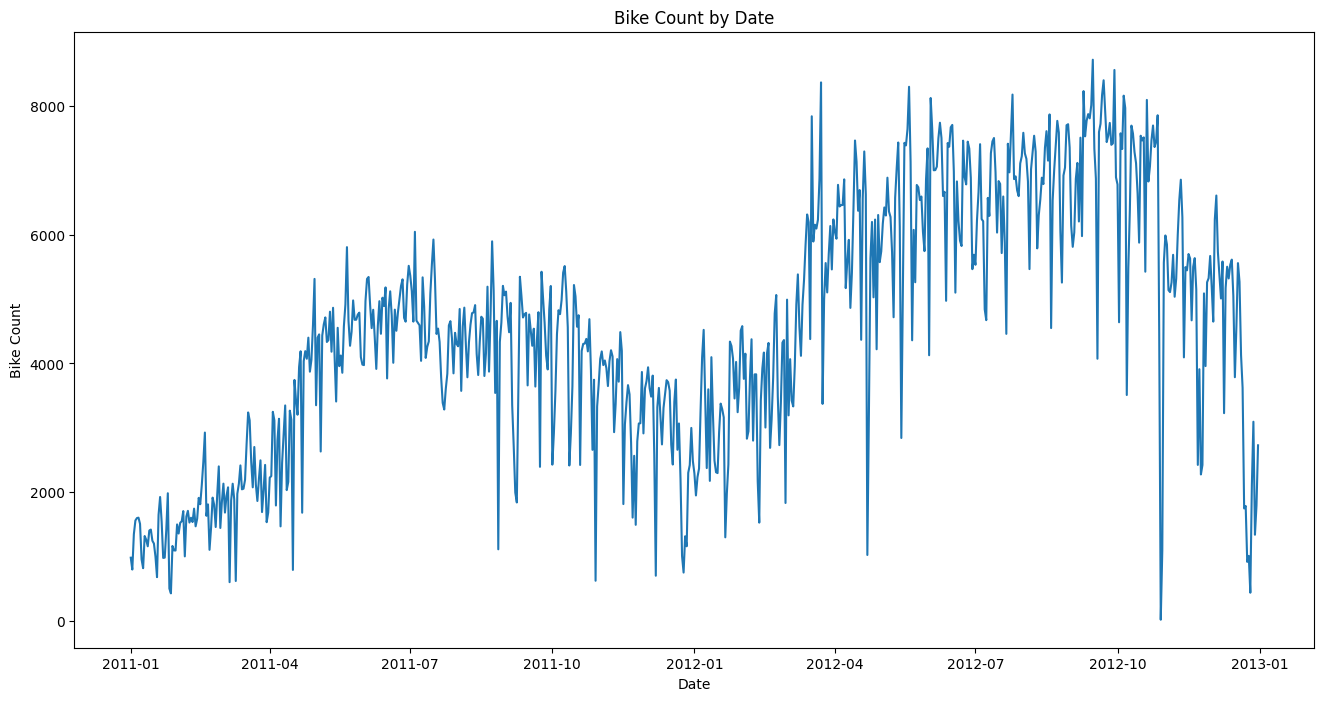

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('Bike Count by Date')
plt.xlabel('Date')
plt.ylabel('Bike Count')
plt.plot(new_df['cnt'])
plt.show()

In [89]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [90]:
# XGBoost Model Training
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Forecasting and Evaluation
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 1315.959716796875
MAE: 1022.9208984375


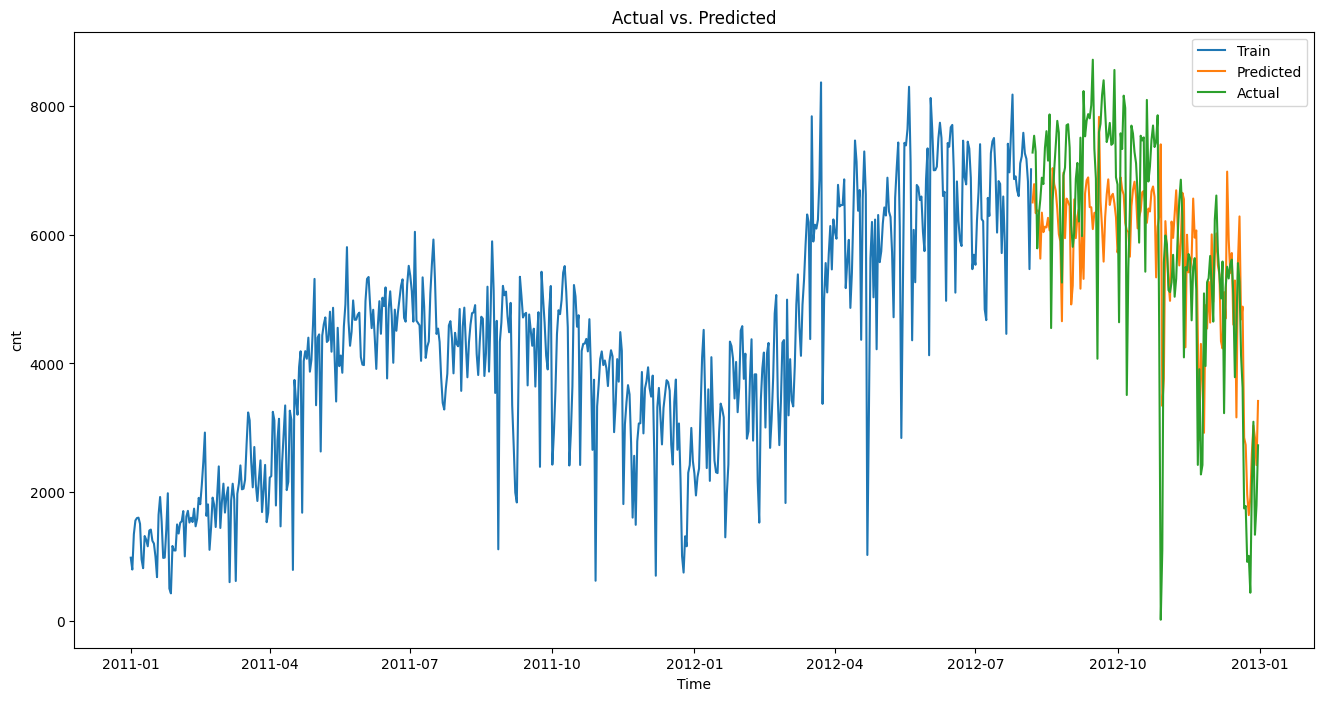

In [91]:
plt.figure(figsize=(16, 8))
plt.title('Bike Count Predictions vs Actual')
plt.plot(X_train.index,y_train.values,label='Train')
plt.plot(X_test.index,y_pred, label='Predicted')
plt.plot(X_test.index,y_test.values, label='Actual')
plt.legend()
plt.xlabel('Time')
plt.ylabel('cnt')
plt.title('Actual vs. Predicted')
plt.show()